In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


AutoEncoder - LSTM

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,losses
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import roc_curve,auc,accuracy_score, precision_score, recall_score,f1_score, classification_report,confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
class Data_process(object):
    def __init__(self,file2='/content/drive/MyDrive/COMP DATA5703/SWAT_with_attack_cleaning_sampling.csv',file1='/content/drive/MyDrive/COMP DATA5703/SWAT_all_normal_data_cleaning_sampling.csv'):
        self.train = pd.read_csv(file1)
        self.test = pd.read_csv(file2)

    def data_scaler(self):
        train_labels = self.train.iloc[:,1]
        trainingdata = self.train.iloc[:, 2:]
        testingdata,test_labels = self.over_sample_smote(self.test.iloc[:, 2:],self.test.iloc[:,1])
        scaler = MinMaxScaler()
        scaler.fit(trainingdata)
        X_train = scaler.transform(trainingdata)
        X_test = scaler.transform(testingdata)
        return X_train,train_labels,X_test,test_labels

    def data_reshape(self,time_step):
        X_train,train_labels,X_test,test_labels = self.data_scaler()
        X_train = X_train.reshape(X_train.shape[0], time_step, X_train.shape[1])
        X_test = X_test.reshape(X_test.shape[0], time_step, X_test.shape[1])
        return X_train,train_labels,X_test,test_labels
        
    def over_sample_smote(self,X,y):
        sm = SMOTE(random_state=0)
        X_res, y_res = sm.fit_resample(X, y)
        return X_res,y_res
    

In [4]:
class AELSTM_MODEL():
    def __init__(self,X_train,train_labels,X_test,test_labels,time_step=1):
        self.model = Sequential([
            LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
            LSTM(16, activation='relu', return_sequences=False),
            RepeatVector(time_step),
            LSTM(16, activation='relu', return_sequences=True),
            LSTM(32, activation='relu', return_sequences=True),
            TimeDistributed(Dense(X_train.shape[2]))
        ])
        self.X_train,self.train_labels,self.X_test,self.test_labels = X_train,train_labels,X_test,test_labels

    def model_train(self,epochs = 40,batch_size = 256,validation_split=0.1):
        self.model.compile(optimizer='adam', loss='mae')
        history = self.model.fit(self.X_train,self.X_train,
                                 epochs=epochs, 
                                 batch_size=batch_size,
                                 validation_split=validation_split).history
        self.model.summary()
        return history

    def plot_loss(self,history):
        fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
        ax.plot(history['val_loss'], 'b', label='Validation loss', linewidth=2)
        ax.plot(history['loss'], 'r', label='Training loss', linewidth=2)
        ax.set_ylabel('MAE loss')
        ax.set_xlabel('Epoch')
        ax.legend(loc='upper right')
        ax.set_title('Model loss Plot', fontsize=12)
        plt.show()

    def plot_dist(self):
        Xpredict = self.model.predict(self.X_train)
        Xpredict = Xpredict.reshape(Xpredict.shape[0], Xpredict.shape[2])

        X_train_reshape = self.X_train.reshape(X_train.shape[0], X_train.shape[2])
        MAE_train = np.mean(np.abs(Xpredict-X_train_reshape), axis = 1)
        plt.figure(figsize=(10,6), dpi=80)
        plt.title('Distribution of loss in training data', fontsize=12)
        sns.distplot(MAE_train, bins = 20, kde= True, color = 'blue');
        plt.xlim([0.0,0.3])
        plt.show()

    def cal_loss_test(self):
        test_pred = self.model.predict(self.X_test)
        test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
        test_pred = pd.DataFrame(test_pred,index=range(test_pred.shape[0]))
        scored_df = pd.DataFrame(index=range(test_pred.shape[0]))
        test_reshape = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[2])
        scored_df['MAELoss'] = np.mean(np.abs(test_pred- test_reshape), axis = 1)
        scored_df['RE Threshold'] = 0.25
        scored_df['Anomaly'] = scored_df['MAELoss'] > scored_df['RE Threshold']
        return scored_df

    def plot_score(self,scored_df):
        scored_df.plot(logy=True,  color=['blue','red'],ylim=[1e-2,1e2], figsize=(16,9) )
        plt.show()

    def class_report(self,y_true, y_pred):
        print("Accuracy = {}".format(accuracy_score(y_true, y_pred)))
        print("Precision = {}".format(precision_score(y_true, y_pred)))
        print("Recall = {}".format(recall_score(y_true, y_pred)))
        print("F1-score ={}".format(f1_score(y_true, y_pred)))
        print(classification_report(y_true, y_pred))


In [5]:
data_process = Data_process()
X_train,train_labels,X_test,test_labels = data_process.data_reshape(1)

In [6]:
aelstm_model = AELSTM_MODEL(X_train,train_labels,X_test,test_labels)
history = aelstm_model.model_train()

Epoch 1/40
59/59 [==============================] - 8s 33ms/step - loss: 0.5778 - val_loss: 0.5138
Epoch 2/40
59/59 [==============================] - 1s 14ms/step - loss: 0.3310 - val_loss: 0.1262
Epoch 3/40
59/59 [==============================] - 1s 11ms/step - loss: 0.1152 - val_loss: 0.0936
Epoch 4/40
59/59 [==============================] - 1s 8ms/step - loss: 0.0988 - val_loss: 0.0866
Epoch 5/40
59/59 [==============================] - 1s 9ms/step - loss: 0.0951 - val_loss: 0.0826
Epoch 6/40
59/59 [==============================] - 0s 8ms/step - loss: 0.0936 - val_loss: 0.0867
Epoch 7/40
59/59 [==============================] - 1s 9ms/step - loss: 0.0925 - val_loss: 0.0796
Epoch 8/40
59/59 [==============================] - 1s 9ms/step - loss: 0.0913 - val_loss: 0.0807
Epoch 9/40
59/59 [==============================] - 1s 9ms/step - loss: 0.0906 - val_loss: 0.0788
Epoch 10/40
59/59 [==============================] - 1s 8ms/step - loss: 0.0902 - val_loss: 0.0781
Epoch 11/40
59/5

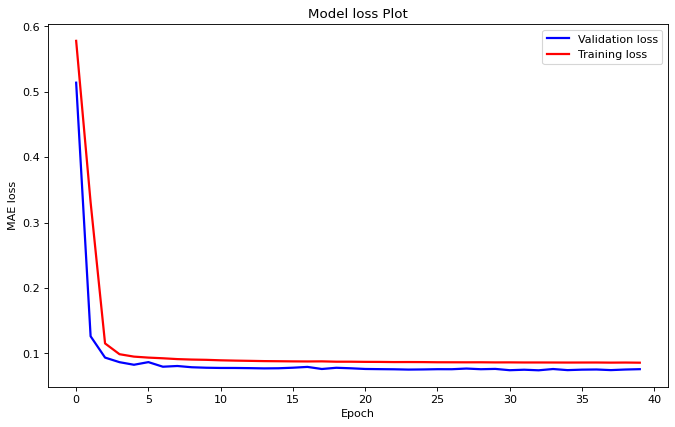

In [7]:
aelstm_model.plot_loss(history)

516/516 [==============================] - 2s 3ms/step


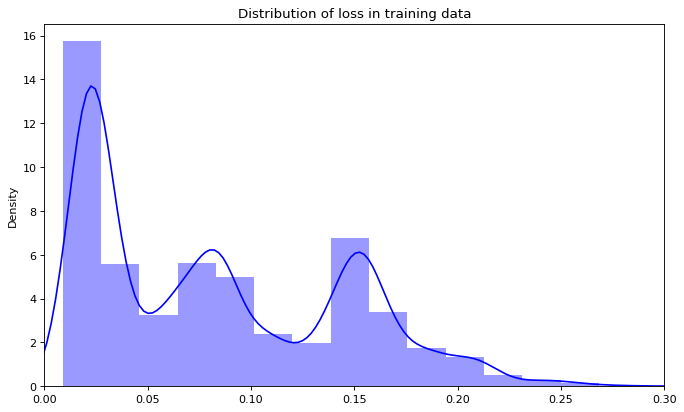

In [8]:
aelstm_model.plot_dist()

In [10]:
scored_df = aelstm_model.cal_loss_test()
scored_df

824/824 [==============================] - 3s 3ms/step


,MAELoss,RE Threshold,Anomaly
0,0.035693,0.25,False
1,0.037446,0.25,False
2,0.036939,0.25,False
3,0.037142,0.25,False
4,0.036812,0.25,False
...,...,...,...
26343,0.365623,0.25,True
26344,0.552084,0.25,True
26345,0.300645,0.25,True
26346,0.274072,0.25,True


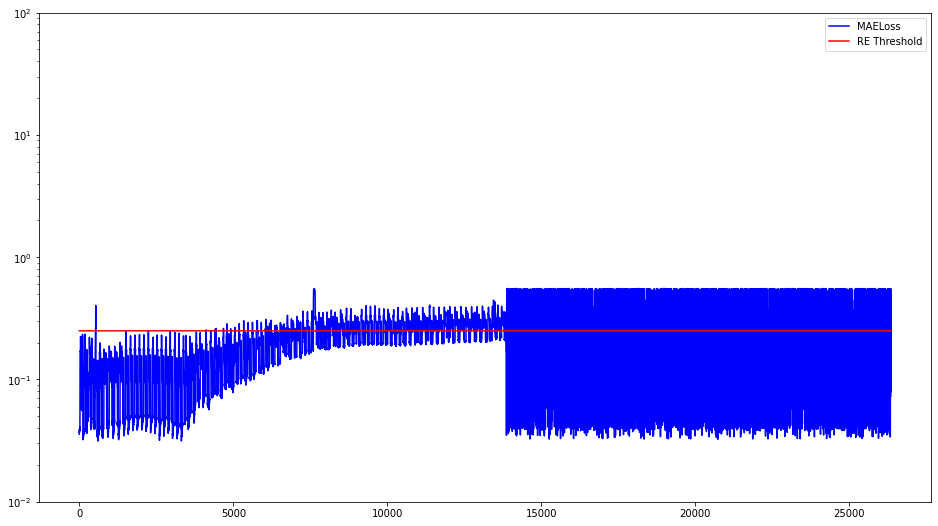

In [11]:
aelstm_model.plot_score(scored_df)

In [12]:
scored['labels'] = aelstm_model.test_labels

In [13]:
scored['Anomaly'] = scored['Anomaly'].apply(lambda x:1 if x==False else -1)

In [14]:
aelstm_model.class_report(scored['labels'],scored['Anomaly'])

Accuracy = 0.5665705176863519
Precision = 0.5484744638514261
Recall = 0.7532260513131926
F1-score =0.6347470095311201
              precision    recall  f1-score   support

          -1       0.61      0.38      0.47     13174
           1       0.55      0.75      0.63     13174

    accuracy                           0.57     26348
   macro avg       0.58      0.57      0.55     26348
weighted avg       0.58      0.57      0.55     26348

